In [1]:
using Pkg; Pkg.activate("./")
#Pkg.develop(path="/Users/kristian/Documents/Git/Entropies.jl")
#Pkg.develop(path="/Users/kristian/Documents/Git/CausalityTools/CausalityToolsBase.jl")

  Activating new project at `~/Code/Repos/Temp/TransferEntropy.jl/src/transferentropy/symbolic`


In [4]:
using Revise

In [12]:
using Entropies, DelayEmbeddings, StaticArrays, Plots

In [14]:
function norm_minmax(v; ϵ = 0.001)
    mini, maxi = minimum(v), maximum(v)
    
    if mini == maxi
        l = length(v)
        return [1/l for i in v]
    else
        ϵ .+ (1-2ϵ)*(v .- mini) ./  (maxi - mini)
    end
end

function quantize(v; n_submotifs = 5)
    mini, maxi = minimum(v), maximum(v)
    r = maxi - mini
    Δx = 1/n_submotifs
    
    x = zero(v)
    for i = 1:length(x)
        x[i] = Δx*floor(Int, v[i]/Δx)
    end
    
    return x
end

"""
A = 1 emphasizes only average values
A = 0 emphasizes changes in amplitude values
A = 0.5 emphasizes equally average values and changes in the amplitude values
"""
function AAPE(a, A=0.5, d::Int = length(a)) where T <: Real
    f = (A/d)*sum(abs.(a)) + (1-A)/(d-1)*sum(abs.(diff(a)))
end

AAPE

In [18]:
"""
    symbolize_amplitudes(x::Dataset{m, T}, N::Int) where {m, T}

Compute amplitude symbols for each of the elements of `x`, encoding 
the absolute amplitude information within each vector `x` (as opposed
to permutation symbols, where only sorting information is included).
"""
function symbolize_amplitudes(x::Dataset{m, T}, N::Int) where {m, T}
    Λ = AAPE.(x.data)
    Λnorm = norm_minmax(Λ)
    return ceil.(Int, Λnorm ./ (1 / N))
end

"""
    symbolize_permamp(x::Dataset{m, T}, N::Int = 5) where {m, T}

Symbolize the points of `x`, using both permutation and absolute 
amplitude information about the x[i]s. Amplitude information is 
discretized into `N` intervals, yielding `N` possible amplitude
symbols.
"""
function symbolize_permamp(x::Dataset{m, T}, N::Int = 5) where {m, T}
    permsymbols = symbolize(x, SymbolicPermutation())
    ampsymbols = symbolize_amplitudes(x, N)
    [SVector{m, T}(x, y) for (x, y) in zip(permsymbols, ampsymbols)]
end

symbolize_permamp

The weights encoding amplitude information about state vector $\mathbf{x}_i = (x_1^i, x_2^i, \ldots, x_m^i)$ are $w_i = \dfrac{A}{m} \sum_{k=1}^m |x_k^i | + \dfrac{1-A}{d-1} \sum_{k=2}^d |x_{k}^i - x_{k-1}^i|$, with $0 \leq A \leq 1$.

With $A=0$ , only internal differences between the elements of $\mathbf{x}_i$) are weighted. With $A=1$, only mean amplitude of the state vector elements are weighted. With, $0<A<1$, a combined weighting is used.

In [33]:
"""
    SymbolicPermutationAmplitude(;N::Int = 5)

A symbolic permutation probabilities estimator that combines permutation information (with motifs of length `m`)
and absolute magnitude information (discretized into `N` intervals, yielding `N` distinct amplitude symbols).

If the estimator is used for entropy computation, then the entropy is computed 
to base `b` (the default `b = 2` gives the entropy in bits).

The motif length must be ≥ 2. By default `m = 2`, which is the shortest 
possible permutation length which retains any meaningful dynamical information.

[^BandtPompe2002]: Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a natural complexity measure for time series." Physical review letters 88.17 (2002): 174102.
"""
struct SymbolicPermutationAmplitude <: Entropies.PermutationProbabilityEstimator
    N::Int
    
    function SymbolicPermutationAmplitude(;N::Int = 5)
        N >= 2 || throw(ArgumentError("The number of amplitude intervals N must be at least 2 (got N=$(N)), otherwise no amplitude information is distinguished."))

        new(N)
    end
end

SymbolicPermutationAmplitude

In [20]:
function entropy(x::Dataset{m, T}, est::SymbolicPermutationAmplitude, α::Real = 1; base = 2) where {m, T}
    m >= 2 || error("Need dimension >= 2 for more than one symbol to be defined.")
    syms = symbolize_permamp(x)
    ps = Entropies.non0hist(syms)
    
    α < 0 && throw(ArgumentError("Order of generalized entropy must be ≥ 0."))
    if α ≈ 0 # Hartley entropy, max-entropy
        return log(base, length(ps)) 
    elseif α ≈ 1
        return -sum( x*log(base, x) for x in ps ) #Shannon entropy
    elseif isinf(α)
        return -log(base, maximum(ps)) #Min entropy
    else
        return (1/(1-α))*log(base, sum(x^α for x in ps) ) #Renyi α entropy
    end
end

entropy (generic function with 2 methods)

In [27]:
x = [(rand(1:10), rand(1:10), rand(1:10)) for x = 1:10000]
symbolize(x, SymbolicPermutation());

In [36]:
symbolize(D, SymbolicPermutationAmplitude())

MethodError: MethodError: no method matching symbolize!(::Vector{Int64}, ::Dataset{3, Float64}, ::SymbolicPermutationAmplitude)
Closest candidates are:
  symbolize!(::AbstractVector{Int64}, ::AbstractDataset{m, T}, !Matched::SymbolicPermutation) where {m, T} at ~/.julia/packages/Entropies/62lBc/src/symbolic/SymbolicPermutation.jl:246
  symbolize!(::AbstractVector{Int64}, !Matched::AbstractVector{T}, !Matched::SymbolicPermutation) where T at ~/.julia/packages/Entropies/62lBc/src/symbolic/SymbolicPermutation.jl:260

In [34]:
m = 3
D = Dataset(rand(10000, m))
@time E1 = genentropy(D, SymbolicPermutationAmplitude(N = 2))
#@time E2 = Entropies.entropy(D, SymbolicPermutation())

MethodError: MethodError: no method matching probabilities(::Dataset{3, Float64}, ::SymbolicPermutationAmplitude)
Closest candidates are:
  probabilities(::AbstractDataset) at ~/.julia/packages/Entropies/62lBc/src/histogram_estimation.jl:44
  probabilities(::AbstractDataset, !Matched::CountOccurrences) at ~/.julia/packages/Entropies/62lBc/src/counting_based/CountOccurrences.jl:14
  probabilities(::AbstractDataset{m, T}, !Matched::SymbolicPermutation) where {m, T} at ~/.julia/packages/Entropies/62lBc/src/symbolic/SymbolicPermutation.jl:287
  ...

# Test 

In [47]:
using DynamicalSystems, Plots, Entropies

ds = Systems.logistic()
rs = 3.5:0.001:4
N_lyap, N_ent = 100000, 50000
D = 6
N = 5
# Generate one time series for each value of the logistic parameter r
lyaps, hs_entropies, hs_permamp = Float64[], Float64[], Float64[]

for r in rs
    ds.p[1] = r
    # Lyapunov exponents
    push!(lyaps, lyapunov(ds, N_lyap))
    
    # For 1D systems `trajectory` returns a vector, so embed it using τs
    # to get the correct 6d dimension on the embedding
    x = trajectory(ds, N_ent)
    τs = ([-i for i in 0:D-1]...,) # embedding lags
    emb = genembed(x, τs)
    
    # Pre-allocate symbol vector, one symbol for each point in the embedding - this is faster!
    s = zeros(Int, length(emb));
    push!(hs_entropies, entropy!(s, emb, SymbolicPermutation(D, b = Base.MathConstants.e)))
    push!(hs_permamp, entropy(emb, SymbolicPermutationAmplitude(D, N = N, b = Base.MathConstants.e)))
end



In [55]:
?lyapunov

search: lyapunov lyapunovs numericallyapunov



```
lyapunov(ds::DynamicalSystem, Τ; kwargs...) -> λ
```

Calculate the maximum Lyapunov exponent `λ` using a method due to Benettin [^Benettin1976], which simply evolves two neighboring trajectories (one called "given" and one called "test") while constantly rescaling the test one. `T`  denotes the total time of evolution (should be `Int` for discrete systems).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the trajectories before starting to measure the expontent. Should be `Int` for discrete systems.
  * `d0 = 1e-9` : Initial & rescaling distance between the two neighboring trajectories.
  * `upper_threshold = 1e-6` : Upper distance threshold for rescaling.
  * `lower_threshold = 1e-12` : Lower distance threshold for rescaling (in order to  be able to detect negative exponents).
  * `dt = 1` : Time of evolution between each check of distance exceeding the thresholds. For continuous systems this is approximate.
  * `inittest = (u1, d0) -> u1 .+ d0/sqrt(D)` : A function that given `(u1, d0)` initializes the test state with distance `d0` from the given state `u1` (`D` is the dimension of the system). This function can be used when you want to avoid the test state appearing in a region of the phase-space where it would have e.g. different energy or escape to infinity.
  * `diffeq...` : Keyword arguments propagated into `init` of DifferentialEquations.jl. See [`trajectory`](@ref) for examples. Only valid for continuous systems.

## Description

Two neighboring trajectories with initial distance `d0` are evolved in time. At time $t_i$ their distance $d(t_i)$ either exceeds the `upper_threshold`, or is lower than `lower_threshold`, which initializes a rescaling of the test trajectory back to having distance `d0` from the given one, while the rescaling keeps the difference vector along the maximal expansion/contraction direction: $u_2 \to u_1+(u_2−u_1)/(d(t_i)/d_0)$.

The maximum Lyapunov exponent is the average of the time-local Lyapunov exponents

$$
\lambda = \frac{1}{t_{n} - t_0}\sum_{i=1}^{n}
\ln\left( a_i \right),\quad a_i = \frac{d(t_{i})}{d_0}.
$$

## Performance Notes

This function uses a [`parallel_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the low level method that accepts an integrator, and `reinit!` it to new initial conditions. See the "advanced documentation" for info on the integrator object. The low level method is

```
lyapunov(pinteg, T, Ttr, dt, d0, ut, lt)
```

[^Benettin1976]: G. Benettin *et al.*, Phys. Rev. A **14**, pp 2338 (1976)


In [54]:
using LaTeXStrings

hs = [hs_permamp; hs_entropies]
hlims = (minimum(hs)*0.9, maximum(hs)*1.05)
p1 = plot(rs, lyaps, label = "", ylabel = L"\lambda", 
    ylims = ylims!(-2, log(2)), c = :black, lw = 1.0)
p2 = plot(rs, hs_permamp, label = "", ylabel = "PE", 
    ylims = hlims, c = :blue)
p3 = plot(rs, hs_entropies, label = "", ylabel = "AAPE", 
    ylims = hlims, c = :red)

plot(p1, p2, p3, layout = grid(3, 1), ms = 1, size = (400, 400))
savefig("Lyap_PE_AAPE_logistic.pdf")

In [ ]:
using PyPlot

f = figure(figsize = (8, 6))
a1 = subplot(311)
plot(rs, lyaps); ylim(-2, log(2)); ylabel("\$\\lambda\$")
a1.axes.get_xaxis().set_ticklabels([])
xlim(rs[1], rs[end]);

a2 = subplot(312)
plot(rs, hs_permamp; color = "C3"); xlim(rs[1], rs[end]); 
xlabel("\$r\$"); ylabel("\$h_6 (permamp)\$")

a3 = subplot(313)
plot(rs, hs_entropies; color = "C2"); xlim(rs[1], rs[end]); 
xlabel("\$r\$"); ylabel("\$h_6 (perm)\$")

a4 = subplot(414)
plot(rs, hs_permamp; color = "C3"); xlim(rs[1], rs[end]); 
xlabel("\$r\$"); ylabel("\$h_6 (permamp)\$")
tight_layout()
savefig("permentropy.png")

## Transfer entropy

In [202]:
import DelayEmbeddings: genembed, AbstractDataset, Dataset
import CausalityToolsBase: optimal_delay, optimal_dimension, OptimiseDelay, OptimiseDim

#export te_embed, EmbeddingTE

function rc(x::Union{AbstractDataset, Vector{T}, Vector{Vector{T}}},
        dim::Union{Int, AbstractVector{Int}, OptimiseDim}, 
        τ::Union{Int, AbstractVector{Int}, OptimiseDelay}, forward = false) where T <: Number
    
    if dim isa OptimiseDim
        if x isa Vector{T} where T <: Number
            dim = optimal_dimension(x, dim)
        elseif x isa Vector{Vector{T}} where T <: Number
            dim = [optimal_dimension(ts, dim) for ts in x]
        elseif x isa AbstractDataset
            dim = [optimal_dimension(x[:, i], dim) for i = 1:size(x, 2)]
        end
    end

    if τ isa OptimiseDelay
        # only optimise if marginal has dimension greater than 1 (the first component 
        # is always constructed with the instantaneous lag, so no need to search for lags for that)
        if dim > 1 
            if x isa Vector{T} where T <: Number
                forward ? τ = optimal_delay(x, τ) : τ = -optimal_delay(x, τ)
            elseif x isa Vector{Vector{T}} where T <: Number
                forward ? τ = [optimal_delay(ts, τ) for ts in x] : τ = -[optimal_delay(ts, τ) for ts in x]
            elseif x isa AbstractDataset
                forward ? τ = [optimal_delay(x[:, i], τ) for i = 1:size(x, 2)] : -[optimal_delay(x[:, i], τ) for i = 1:size(x, 2)]
            end
        else 
            τ = -1
        end
    end
    
    if x isa Vector{T} where T <: Number
        # Fixed dimension, fixed lag
        if dim isa Int && τ isa Int            
            pos = [1 for x in dim:-1:1]
            if τ > 0
                lags = [d*τ for d in dim:-1:1]
            elseif τ <= 0 && forward
                lags = [d*τ for d in dim:-1:1]
            elseif τ <= 0 && !forward
                lags = [d*τ for d in 0:(dim-1)]
            end
        end
        
        # Fixed dimension, multiple lags (number of lags must match dimension)
        if dim isa Int && length(τ) > 1
            length(τ) == dim || throw(ArgumentError("length(τ) must equal dim if multiple lags are specified manually (got length(τ) = $(length(τ)), dim=$(dim))"))
            length(unique(τ)) == length(τ) || throw(ArgumentError("Tried to specify reconstruction lags manually, but there are repeated lags. Provide unique lags."))
            pos = pos = [1 for x in dim:-1:1]
            return pos, τ
        end
    end

    # Multiple time series input
    if (x isa Vector{Vector{T}} where T <: Number) || (x isa AbstractDataset)
        if x isa AbstractDataset 
            N = length(x)
        elseif x isa Vector{Vector{T}} where T <: Number
            N = size(x, 1)
        end


        if dim isa Int
            dim % N == 0 || throw(ArgumentError("If using multiple (`N` different) time series in a marginal, each time series is lagged `dim/N` times. Hence, `dim` must be a multiple of `N`."))

            lD = Int(dim / N) # "local" reconstruction dimension for this time series
                
            pos = Vector{Int}(undef, 0)

            for i = 1:N
                append!(pos, repeat([i], lD))
            end
            
            if τ isa Int
                if τ > 0
                    llags = [d*τ for d in lD:-1:1]
                elseif τ <= 0 && forward
                    llags = [d*τ for d in lD:-1:1]
                elseif τ <= 0 && !forward
                    llags = [d*τ for d in 0:(lD - 1)]
                end
                lags = repeat(llags, Int(dim/lD))
            elseif τ isa AbstractVector{Int}
                length(τ) == N || throw(ArgumentError("Tried using `N = $N` different time series in a marginal, but $(length(τ)) reconstruction lags were provided. The number of lags must equal `N`"))
                lags = Vector{Int}(undef, 0)
                for i = 1:length(x)
                    if τ[i] > 0
                        llags = [d*τ[i] for d in lD:-1:1]
                    elseif τ[i] <= 0 && forward
                        llags = [d*τ[i] for d in 0:(lD - 1)]
                    elseif τ[i] <= 0 && !forward
                        llags = [d*τ[i] for d in 0:(lD - 1)]
                    end
                    append!(lags, llags)
                end
            end
        end
        
        if dim isa AbstractVector{Int}
            length(dim) == N || throw(ArgumentError("There must be precisely one dimension specification per time series. Got $(length(dim)) specifications for $N time series."))
            pos = Vector{Int}(undef, 0)
            lags = Vector{Int}(undef, 0)

            for (i, lD) in enumerate(dim)
                append!(pos, repeat([i], lD))
                
                if τ isa Int
                    if τ > 0
                        llags = [d*τ for d in lD:-1:1]
                    elseif τ <= 0 && !forward
                        llags = [d*τ for d in lD:-1:1]
                    elseif τ <= 0 && forward
                        llags = [d*τ for d in 0:(lD - 1)]
                    end
                    append!(lags, llags)
                elseif τ isa AbstractVector{Int}
                    length(τ) == N || throw(ArgumentError("Tried using `N = $N` different time series in a marginal, but $(length(τ)) reconstruction lags were provided. The number of lags must equal `N`"))
                    if τ[i] > 0
                        llags = [d*τ[i] for d in lD:-1:1]
                    elseif τ[i] <= 0 && forward
                        llags = [d*τ[i] for d in lD:-1:1]
                    elseif τ[i] <= 0 && !forward
                        llags = [d*τ[i] for d in 0:(lD - 1)]
                    end
                    append!(lags, llags)
                end
            end
        end
    end
    return pos, lags
end


"""
    EmbeddingTE(; dS = 1, dT = 1, d𝒯 = 1, dC = 1, τS = -1, τT = -1, η𝒯 = 1, τC = -1)

Embedding parameters for transfer entropy analysis. 

## Convention for generalized delay reconstruction

This struct contains instructions for transfer entropy computations using the following convention.
Let ``x(t)`` be time series for the source variable, ``y(t)`` be the time series for the target variable and 
``z(t)`` the time series for any conditional variable. To compute transfer entropy, we need the 
following marginals:


```math
\\begin{aligned}
\\mathcal{T}^{(d_{\\mathcal{T}})} &= \\{(y(t+\\eta^{d_{\\mathcal{T}}}), \\ldots, y(t+\\eta^2), y(t+\\eta^1) \\} \\\\
T^{(d_{T})} &= \\{ (y(t+\\tau^0_{T}), y(t+\\tau^1_{T}), y(t+\\tau^2_{T}), \\ldots, y(t + \\tau^{d_{T} - 1}_{T})) \\} \\\\
S^{(d_{S})} &= \\{ (x(t+\\tau^0_{S}), x(t+\\tau^1_{S}), x(t+\\tau^2_{S}), \\ldots, x(t + \\tau^{d_{S} - 1}_{S})) \\} \\\\
C^{(d_{C})} &= \\{ (z(t+\\tau^0_{C}), z(t+\\tau^1_{C}), z(t+\\tau^2_{C}), \\ldots, z(t + \\tau^{d_{C} - 1}_{C})) \\}
\\end{aligned}
```

Depending on the application, the delay reconstruction lags ``\\tau^k_{T} \\leq 0``, ``\\tau^k_{S} \\leq 0``, and ``\\tau^k_{C} \\leq 0`` 
may be equally spaced, or non-equally spaced. The predictions lags ``\\eta^k``may also be equally spaced 
or non-equally spaced, but are always positive. For transfer entropy, convention dictates that at least one 
``\\tau^k_{T}``, one ``\\tau^k_{S}`` and one ``\\tau^k_{C}`` equals zero. This way, the ``T``, ``S`` and ``C`` marginals 
always contains present/past states, 
while the ``\\mathcal T`` marginal contain future states relative to the other marginals. 

Combined, we get the generalized delay reconstruction ``\\mathbb{E} = (\\mathcal{T}^{(d_{\\mathcal{T}})}, T^{(d_{T})}, S^{(d_{S})}, C^{(d_{C})})``. Transfer entropy is then computed as 

```math
\\begin{aligned}
TE_{S \\rightarrow T | C} = \\int_{\\mathbb{E}} P(\\mathcal{T}, T, S, C) \\log_{b}{\\left(\\frac{P(\\mathcal{T} | T, S, C)}{P(\\mathcal{T} | T, C)}\\right)},
\\end{aligned}
```

or, if conditionals are not relevant,

```math
\\begin{aligned}
TE_{S \\rightarrow T} = \\int_{\\mathbb{E}} P(\\mathcal{T}, T, S) \\log_{b}{\\left(\\frac{P(\\mathcal{T} | T, S)}{P(\\mathcal{T} | T)}\\right)},
\\end{aligned}
```

Here, 

- ``\\mathcal{T}`` denotes the ``d_{\\mathcal{T}}``-dimensional set of vectors furnishing the future states of ``T``,
- ``T`` denotes the ``d_{T}``-dimensional set of vectors furnishing the past and present states of ``T``, 
- ``S`` denotes the ``d_{S}``-dimensional set of vectors furnishing the past and present of ``S``, and 
- ``C`` denotes the ``d_{C}``-dimensional set of vectors furnishing the past and present of ``C``.

## Keyword arguments 

### Specifying dimensions for generalized delay reconstructions of marginals

`dS`, `dT`, `d𝒯`, and `dC` are the dimensions of the ``S``, ``T``, ``\\mathcal{T}``, 
and ``C`` marginals. The dimensions of each marginal can be specified manually by setting 
either `dS`, `dT`, `d𝒯`, or `dC` to a *positive* integer number. Alternatively, the dimension
of each marginal can be optimised by setting either `dS`, `dT`, `d𝒯`, or `dC` to an 
instance of [`OptimiseDim`](@ref) 
(e.g. `EmbeddingTE(dT = OptimDim(method_delay = "ac_zero", method_dim = "f1nn")`).

### Specifying delays for generalized delay reconstructions of marginals

The corresponding embedding delay lags are given by `τS`, `τT` and `τC`. The delays
for each marginal can be specified manually by setting either `dS`, `dT`, `d𝒯`, or `dC` 
to a *negative* integer number. The delay defaults for each marginal is -1 (but is set to zero 
if the marginal is one-dimensional), and must always be negative. Alternatively, delays can 
be estimated numerically by setting either `dS`, `dT`, `d𝒯`, and `dC` 
to an instance of [`OptimiseDelay`](@ref) (e.g. `dS = OptimiseDelay(method_delay = "ac_zero")`).

The prediction lag `η` can be either positive or negative, but should not be zero. 

In summary, one can provide

- A single delay ``\\tau``, in which case ``\\tau_{T} = \\{0, \\tau, 2\\tau, \\ldots, (d_{T}- 1)\\tau \\}``, or 
- All the delays manually. If so, then the number of delays must match the dimension of the marginal). 

For the prediction lag, one can provide 

- A single delay ``\\eta_f``, in which case ``\\eta_{\\mathcal{T}} = \\{\\eta_f, 2\\eta_f, \\ldots, (d_{\\mathcal{T}} - 1)\\eta_f \\}``, or 
- All the delays manually. If so, then the number of delays must equal ``d_{\\mathcal{T}}``, which is the dimension of the marginal). 

!!! note
    If both the delay and the dimension for a given marginal is to be estimated numerically, make sure 
    to use the same delay estimation method for both 
    the [`OptimiseDelay`](@ref) and  [`OptimiseDim`](@ref) instances.

## Examples

Default parameters: 

```jldoctest
using CausalityTools
p = EmbeddingTE()

# output
EmbeddingTE(dS=1, dT=1, dC=1, d𝒯=1, τS=-1, τT=-1, τC=-1, η𝒯=1)
```

Optimising parameters for the target variable's history (the ``T`` component):

```jldoctest
using CausalityTools
p = EmbeddingTE(
    dT = OptimiseDim(method_delay = "ac_zero", method_dim = "f1nn"),
    τT = OptimiseDelay(method_delay = "ac_zero")
)

# output
EmbeddingTE(dS=1, dT=OptimiseDim(method_delay = ac_zero, method_dim = f1nn, maxdim = 6, maxdelay_frac = 0.1), dC=1, d𝒯=1, τS=-1, τT=OptimiseDelay(method_delay = ac_zero, maxdelay_frac = 0.1), τC=-1, η𝒯=1)
```
"""
@Base.kwdef struct EmbeddingTE
    dS::Union{Int, AbstractVector{Int}, OptimiseDim} = 1
    dT::Union{Int, AbstractVector{Int}, OptimiseDim} = 1
    d𝒯::Union{Int, AbstractVector{Int}, OptimiseDim} = 1
    dC::Union{Int, AbstractVector{Int}, OptimiseDim, Nothing} = 1
    τS::Union{Int, AbstractVector{Int}, OptimiseDelay} = -1
    τT::Union{Int, AbstractVector{Int}, OptimiseDelay} = -1
    η𝒯::Union{Int, AbstractVector{Int}, OptimiseDelay} = 1
    τC::Union{Int, AbstractVector{Int}, OptimiseDelay, Nothing} = -1

    function EmbeddingTE(
            dS::Union{Int, AbstractVector{Int}, OptimiseDim}, 
            dT::Union{Int, AbstractVector{Int}, OptimiseDim}, 
            d𝒯::Union{Int, AbstractVector{Int}, OptimiseDim}, 
            dC::Union{Int, AbstractVector{Int}, OptimiseDim}, 
            τS::Union{Int, AbstractVector{Int}, OptimiseDelay}, 
            τT::Union{Int, AbstractVector{Int}, OptimiseDelay}, 
            η𝒯::Union{Int, AbstractVector{Int}, OptimiseDelay}, 
            τC::Union{Int, AbstractVector{Int}, OptimiseDelay})
        
        if dS isa Int
            dS > 0 || throw(ArgumentError("dimension for marginal S must be a positive integer (got dS=$(dS))"))
        end
        if dT isa Int
            dT > 0 || throw(ArgumentError("dimension for marginal T must be a positive integer (got dT=$(dT))"))
        end
        if dC isa Int
            dC > 0 || throw(ArgumentError("dimension for marginal C must be a positive integer (got dC=$(dC))"))
        end
        if d𝒯 isa Int
            d𝒯 > 0 || throw(ArgumentError("dimension for marginal 𝒯 must be a positive integer (got d𝒯=$(d𝒯))"))
        end
        if τS isa Int
            τS < 0 || throw(ArgumentError("delay for marginal S must be a negative integer (got τS=$(τS))"))
        end
        if τT isa Int
            τT < 0 || throw(ArgumentError("delay for marginal T must be a negative integer (got τT=$(τT))"))
        end
        if τC isa Int
            τC < 0 || throw(ArgumentError("delay for marginal C must be a negative integer (got τC=$(τC))"))
        end

        if τS isa AbstractVector{Int} || τS isa AbstractUnitRange{Int64}
            all(τS .<= 0) || throw(ArgumentError("delays for marginal S must be <= 0 (got τS=$(τS))"))
        end

        if τT isa AbstractVector{Int} || τT isa AbstractUnitRange{Int64}
            all(τT .<= 0) || throw(ArgumentError("delays for marginal T must be <= 0 (got τT=$(τT))"))
        end

        if τC isa AbstractVector{Int} || τC isa AbstractUnitRange{Int64}
            all(τC .<= 0) || throw(ArgumentError("delays for marginal C must be <= 0 (got τC=$(τC))"))
        end

        new(dS, dT, d𝒯, dC, τS, τT, η𝒯, τC)
    end
    
end

function Base.show(io::IO, x::EmbeddingTE)
    s = "EmbeddingTE(dS=$(x.dS), dT=$(x.dT), dC=$(x.dC), d𝒯=$(x.d𝒯), τS=$(x.τS), τT=$(x.τT), τC=$(x.τC), η𝒯=$(x.η𝒯))"
    print(io, s)
end

function get_delay_reconstruction_params(source, target, p::EmbeddingTE)
    pos_𝒯, lags_𝒯 = rc(target, p.d𝒯, p.η𝒯, true)
    pos_T, lags_T = rc(target, p.dT, p.τT, false)
    pos_S, lags_S = rc(source, p.dS, p.τS, false)
    pos_C, lags_C = rc(source, p.dC, p.τC, false)

    js = ([pos_𝒯; pos_T; pos_S]...,)
    τs = ([lags_𝒯; lags_T; lags_S]...,)

    return τs, js
end

function get_delay_reconstruction_params(source, target, cond, p::EmbeddingTE)
    pos_𝒯, lags_𝒯 = rc(target, p.d𝒯, p.η𝒯, true)
    pos_T, lags_T = rc(target, p.dT, p.τT, false)
    pos_S, lags_S = rc(source, p.dS, p.τS, false)
    pos_C, lags_C = rc(cond, p.dC, p.τC, false)

    js = ([pos_𝒯; pos_T; pos_S; pos_C]...,)
    τs = ([lags_𝒯; lags_T; lags_S; pos_C]...,)

    return τs, js
end

"""
    te_embed(source::AbstractVector{T}, target::AbstractVector{T}, p::EmbeddingTE) → (points, vars, τs)
    te_embed(source::AbstractVector{T}, target::AbstractVector{T}, cond::AbstractVector{T}, p::EmbeddingTE) → (points, vars, τs)

Generalised delay reconstruction of `source` and `target` (and `cond` if provided) 
for transfer entropy computation using embedding parameters provided by the [`EmbeddingTE`](@ref)
instance `p`.

Returns a tuple of the embedded `points`, `vars` (a [`TEVars`](@ref) instance that keeps track of which 
variables of the embedding belong to which marginals of the reconstruction; indices are: source = 1, 
target = 2, cond = 3), and a tuple `τs`, which stores the lags for each variable of the reconstruction.
"""
function te_embed(source::AbstractVector{T}, target::AbstractVector{T}, p::EmbeddingTE) where T
    
    #@show p.τS
    #if (p.τS isa Int && p.τS > 0) || (length(p.τS) > 1 && any(p.τS[p.τS .> 0]))
    #    @warn("Backwards lag τS should be negative. You might be getting nonsensical results!")
    #end
    
    # Get lags and posisions separately for each marginal
    pos_𝒯, lags_𝒯 = rc(target, p.d𝒯, p.η𝒯, true)
    pos_T, lags_T = rc(target, p.dT, p.τT, false)
    pos_S, lags_S = rc(source, p.dS, p.τS, false)
    
    # Add one to the index of the positions for the target (rc doesn't know it is in fact our second time series)
    # TODO: make sure this works when `source` and `target` are multiple time series
    pos_𝒯 .= pos_𝒯 .+ 1
    pos_T .= pos_T .+ 1
    
    js = ([pos_𝒯; pos_T; pos_S]...,)
    τs = ([lags_𝒯; lags_T; lags_S]...,)
    
    # TODO: This only works for single time series at the moment
    ts = Dataset(source, target)
    
    # The reconstructed points
    pts = genembed(ts, τs, js)
    d𝒯 = length(pos_𝒯)
    dT = length(pos_T)
    dS = length(pos_S)

    # Which columns/variables map to which marginals?
    vars = TEVars(
        𝒯  = 1:(d𝒯)           |> collect, 
        T = 1+(d𝒯):dT+(d𝒯)     |> collect, 
        S = 1+(dT+d𝒯):dS+(d𝒯+dT) |> collect)

    return pts, vars, τs, js
end

function te_embed(source::AbstractVector{T}, target::AbstractVector{T}, cond::AbstractVector{T}, p::EmbeddingTE) where T
    
    #@show p.τS
    #if (p.τS isa Int && p.τS > 0) || (length(p.τS) > 1 && any(p.τS[p.τS .> 0]))
    #    @warn("Backwards lag τS should be negative. You might be getting nonsensical results!")
    #end
    # Get lags and posisions separately for each marginal
    pos_𝒯, lags_𝒯 = rc(target, p.d𝒯, p.η𝒯,  true)
    pos_T, lags_T = rc(target, p.dT, p.τT, false)
    pos_S, lags_S = rc(source, p.dS, p.τS, false)
    pos_C, lags_C = rc(cond,   p.dC, p.τC, false)

    # Add one to the index of the positions for the target (rc doesn't know it is in fact our second time series)
    # TODO: make sure this works when `source` and `target` are multiple time series
    pos_𝒯 .= pos_𝒯 .+ 1
    pos_T .= pos_T .+ 1
    pos_C .= pos_C .+ 2

    js = ([pos_𝒯; pos_T; pos_S; pos_C]...,)
    τs = ([lags_𝒯; lags_T; lags_S; lags_C]...,)
    
    # TODO: This only works for single time series at the moment
    ts = Dataset(source, target, cond)
    
    # The reconstructed points
    pts = genembed(ts, τs, js)
    d𝒯 = length(pos_𝒯)
    dT = length(pos_T)
    dS = length(pos_S)
    dC = length(pos_C)

    # Which columns/variables map to which marginals?
    vars = TEVars(
        𝒯 = 1:(d𝒯)               |> collect, 
        T = 1+(d𝒯):dT+(d𝒯)         |> collect, 
        S = 1+(dT+d𝒯):dS+(d𝒯+dT)     |> collect,
        C = 1+(dT+d𝒯+dS):dC+(d𝒯+dT+dS) |> collect)

    return pts, vars, τs, js
end


"""
    TEVars(𝒯::Vector{Int}, T::Vector{Int}, S::Vector{Int})
    TEVars(𝒯::Vector{Int}, T::Vector{Int}, S::Vector{Int}, C::Vector{Int})
    TEVars(;𝒯 = Int[], T = Int[], S = Int[], C = Int[]) -> TEVars

Which axes of the state space correspond to the future of the target (`𝒯`),
the present/past of the target (`T`), the present/past of the source (`S`), and
the present/past of any conditioned variables (`C`)?  This information is used by 
the transfer entropy estimators to ensure that marginal distributions are computed correctly.

Indices correspond to variables of the embedding, or, equivalently, colums of a `Dataset`.

- The three-argument constructor assumes there will be no conditional variables.
- The four-argument constructor assumes there will be conditional variables.

"""
struct TEVars
    𝒯::Vector{Int}
    T::Vector{Int}
    S::Vector{Int}
    C::Vector{Int}
end

"""
    TEVars(𝒯::Vector{Int},
            T::Vector{Int},
            S::Vector{Int})

Which axes of the state space correspond to the future of the target,
the present/past of the target, and the present/past of the source?
Indices correspond to variables of the embedding or colums of a `Dataset`.

This information is used by the transfer entropy estimators to ensure
the marginal distributions are computed correctly.

This three-argument constructor assumes there will be no conditional variables.
"""
TEVars(𝒯::Vector{Int}, T::Vector{Int}, S::Vector{Int}) = TEVars(𝒯, T, S, Int[])

TEVars(;𝒯::Vector{Int} = Int[],
	    T::Vector{Int} = Int[],
	    S::Vector{Int} = Int[],
		C::Vector{Int} = Int[]) =
	TEVars(𝒯, T, S, C)
    
function Base.show(io::IO, tv::TEVars) 
    s = "$(typeof(tv))(𝒯 = $(tv.𝒯), T = $(tv.T), S = $(tv.S), C = $(tv.C))"
    print(io, s)
end

export TEVars


In [540]:
function transferentropy(source, target, embedding::EmbeddingTE, est::SymbolicPermutation)
    # Generalized embeddings of each marginal separately.
    # Use provided delays, but overwrite dimensions with `m`
    # (all marginals must have dimension `m` to have symbols 
    # of length `m`)
    m = est.m
    symbolemb = EmbeddingTE(dT = m, 
                            dS = m, 
                            dC = m, 
                            d𝒯 = m, 
                            τT = embedding.τT,
                            τS = embedding.τS,
                            τC = embedding.τC,
                            η𝒯 = embedding.η𝒯)
    pts, vars, τs, js = te_embed(source, target, symbolemb)

    E𝒯 = pts[:, 1:m]       
    ET = pts[:, m+1:2*m]   
    ES = pts[:, 2*m+1:end] 
    
    # Symbolize each marginal separately
    s𝒯 = symbolize(E𝒯, est)
    sT = symbolize(ET, est)
    sS = symbolize(ES, est)
    
    ST = Entropies.non0hist(Dataset(sS, sT).data)
    T𝒯 = Entropies.non0hist(Dataset(sT, s𝒯).data)
    T = Entropies.non0hist(Dataset(sT).data)
    joint = Entropies.non0hist(Dataset(s𝒯, sT, sS).data)
    
    te = Entropies.genentropy(1, ST, base = est.b) +
         Entropies.genentropy(1, T𝒯, base = est.b) -
         Entropies.genentropy(1, T, base = est.b) -
         Entropies.genentropy(1, joint, base = est.b)
end

function transferentropy(source, target, embedding::EmbeddingTE, est::SymbolicPermutationAmplitude)
    # Generalized embeddings of each marginal separately.
    # Use provided delays, but overwrite dimensions with `m`
    # (all marginals must have dimension `m` to have symbols 
    # of length `m`)
    m = est.m
    symbolemb = EmbeddingTE(dT = m, 
                            dS = m, 
                            dC = m, 
                            d𝒯 = m, 
                            τT = embedding.τT,
                            τS = embedding.τS,
                            τC = embedding.τC,
                            η𝒯 = embedding.η𝒯)
    pts, vars, τs, js = te_embed(source, target, symbolemb)

    E𝒯 = pts[:, 1:m]       
    ET = pts[:, m+1:2*m]   
    ES = pts[:, 2*m+1:end] 
  
    # Symbolize each marginal separately
    s𝒯 = symbolize(E𝒯, est)
    sT = symbolize(ET, est)
    sS = symbolize(ES, est)

    ST = Entropies.non0hist(Dataset(sS, sT).data)
    T𝒯 = Entropies.non0hist(Dataset(sT, s𝒯).data)
    T =  Entropies.non0hist(Dataset(sT).data)
    joint = Entropies.non0hist(Dataset(s𝒯, sT, sS).data)
    
    te = Entropies.genentropy(1, ST, base = est.b) +
         Entropies.genentropy(1, T𝒯, base = est.b) -
         Entropies.genentropy(1, T, base = est.b) -
         Entropies.genentropy(1, joint, base = est.b)
end

transferentropy (generic function with 2 methods)

In [205]:
ET = [(rand(1:5), rand(1:5)) for i = 1:10]
ES = [(rand(1:5), rand(1:5)) for i = 1:10]

x = rand(100)
y = rand(100)
emb = EmbeddingTE()

transferentropy(x, y, emb, SymbolicPermutationAmplitude(4))
#@time Dataset([SVector((x..., y...,)) for (x, y) in zip(ET, ES)])

0.8095076614531687

## Example system: unidir logistic

In [206]:
using StatsBase, Statistics, Distributions, DynamicalSystems

"""
Add observational noise to a dataset from a normal distribution with zero mean 
and standard deviation equivalent to some fraction of the empirical standard 
deviation along each variable of the dataset.
"""
function add_observational_noise!(x::AbstractArray{T, 2}, percent_noise) where T
    
    dims = size(x)
    if percent_noise > 0 
        if dims[1] > dims[2]
            nvars = dims[2]
            npts = dims[1]
            
            for i = 1:nvars
                dist = Normal(0, (percent_noise/100) * std(x[:, i]))
                x[:, i] .+= rand(dist, npts)
            end
        else
            nvars = dims[1]
            npts = dims[2]
            
            for i = 1:nvars
                dist = Normal(0, (percent_noise/100) * std(x[i, :]))
                x[i, :] .+= rand(dist, npts)
            end
        end
    end
    
    return x
end

function add_observational_noise!(data::Dataset{dim, T}, percent_noise) where {dim, T}
    D = dim
    L = length(data)
    noisy_data = zeros(T, L, D)
    if percent_noise > 0 
        σs = [Normal(0, (percent_noise/100)*std(col)) for col in columns(data)]
        for i = 1:D
            noisy_data[:, i] = data[:, i] .+ rand(σs[i], L)
        end
        return Dataset(noisy_data)
    end
    return data
end

add_observational_noise! (generic function with 2 methods)

In [588]:
using Distributions
struct LogisticUnidirModel
    ui::Vector{AbstractFloat}
    r₁::AbstractFloat
    r₂::AbstractFloat
    c_xy::AbstractFloat
    σ::AbstractFloat
    observational_noise_level # how much observational noise to add?
end

"""
    LogisticUnidirModel(; r₁ = 3.8, r₂ = 3.7, σ = 0.3, c_xy = 0.3)

Generate a 2D system of unidirectionally coupled logistic maps, where `c_xy`
controls the strength of the influence of `x` to `y`.
"""
function LogisticUnidirModel(; r₁ = 3.8, r₂ = 3.7, σ = 0.3, c_xy = 0.3, ui = rand(2), observational_noise_level = 0.2)
    if length(ui) != 2
        error("Number of elements in initial condition must match 2")
    end
    LogisticUnidirModel(ui, r₁, r₂, c_xy, σ, observational_noise_level)
end

function Base.show(io::IO, x::LogisticUnidirModel)
    print(io, "$(typeof(x))(nvars=2, r₁=$(x.r₁), r₂=$(x.r₂), c_xy=$(x.c_xy), observational_noise_level=$(x.observational_noise_level)")
end;

function trajectory(m::LogisticUnidirModel, n::Int; Ttr::Int = 100)
    
    c_xy = m.c_xy
    r₁ = m.r₁
    r₂ = m.r₂
    σ = m.σ
    
    O = zeros(Float64, n + Ttr, 2)
    O[1, :] = m.ui
    
    for t = 2:(n+Ttr)
        x = O[t-1, 1]
        y = O[t-1, 2]
        ξ = rand() # random number from flat distribution on [0, 1]
        f_xy = (y +  (c_xy*(x + σ*ξ)/2) ) / (1 + (c_xy/2)*(1+σ))
        O[t, 1] = r₁ * x * (1 - x)
        O[t, 2] = r₂ * (f_xy) * (1 - f_xy)
    end
        
    if m.observational_noise_level > 0
        O = add_observational_noise!(O, m.observational_noise_level)
    end
    return O[Ttr+1:end, :]
end
    

function interaction_matrix(m::LogisticUnidirModel)
    C = m.c_xy
    
    if C == 0
        return zeros(Int, 2, 2)
    else
        X = [0 1; 
             0 0]
        return X
    end
end

function model_chaotic(m::Type{LogisticUnidirModel}, n::Int; Ttr::Int = 100,
        c_xy = 0.1, 
        Dui = Uniform(0, 1),
        Dr₁ = Uniform(3.6, 4.0), 
        Dr₂ = Uniform(3.6, 4.0),
        σ = 0.2, 
        observational_noise_level = 0.5,
        n_maxtries = 200)
    
    n_tries = 0
    while n_tries <= n_maxtries
        
        model = LogisticUnidirModel(
            ui = rand(Dui, 2),
            r₁ = rand(Dr₁),
            r₂ = rand(Dr₂),
            c_xy = c_xy,
            σ = σ,
            observational_noise_level = 0)
        
        
        O = trajectory(model, n, Ttr = Ttr)
        # Ensure there are not too many repeated values, so we don't have trivial behaviour
        
        if length(unique(O[:, 1])) > n * 0.95 && length(unique(O[:, 2])) > n * 0.95 
            return LogisticUnidirModel(model.ui, 
                model.r₁,
                model.r₂,
                model.c_xy,
                model.σ,
                observational_noise_level)
        end
        
        n_tries += 1
    end
end

model_chaotic (generic function with 1 method)

## Application of symnbolic TE 

In [598]:
function doit_permamp(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, m = 3, N = 5, A = 0.5, b = 2)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            orbit = trajectory(model_chaotic(LogisticUnidirModel, npts, c_xy = c_xy), npts)
            D = Dataset(orbit);
            x, y = columns(D)
            emb = EmbeddingTE()
            xy = transferentropy(x, y, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            yx = transferentropy(y, x, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

function doit_perm(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, m = 3, N = 5, b = 2)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            orbit = trajectory(model_chaotic(LogisticUnidirModel, npts, c_xy = c_xy), npts)
            D = Dataset(orbit);
            x, y = columns(D)
            emb = EmbeddingTE()
            xy = transferentropy(x, y, emb, SymbolicPermutation(m, b = b))
            yx = transferentropy(y, x, emb, SymbolicPermutation(m, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

doit_perm (generic function with 1 method)

## Example application: logistic maps

In [626]:
D = 3
N = 10
c_xys = 0.0:0.05:2.0
ncoups = length(c_xys)
npts = 4000
nreps = 1000

tes_xy_permamp_A0, tes_yx_permamp_A0 = doit_permamp(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0);
tes_xy_permamp_A025, tes_yx_permamp_A025 = doit_permamp(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.25);
tes_xy_permamp_A05, tes_yx_permamp_A05 = doit_permamp(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.5);
tes_xy_permamp_A075, tes_yx_permamp_A075 = doit_permamp(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.75);
tes_xy_permamp_A1, tes_yx_permamp_A1 = doit_permamp(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 1);

tes_xy_perm, tes_yx_perm = doit_perm(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys);


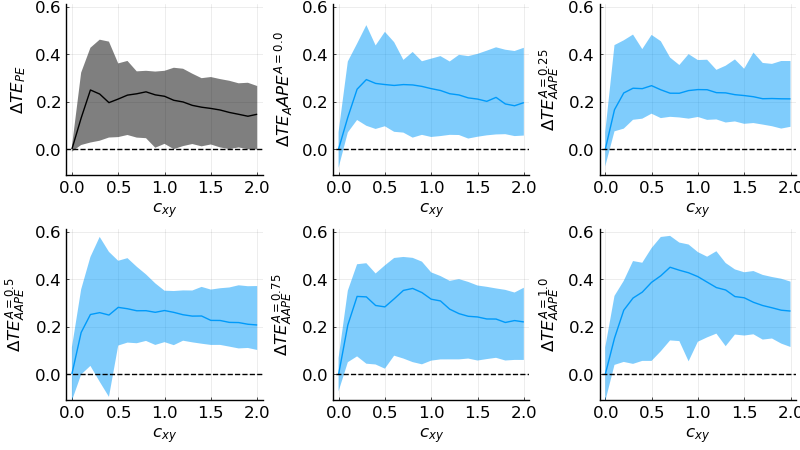

In [625]:
pyplot() ; using LaTeXStrings
lq, uq = 0.025, 0.975

X_permamp_A0 = hcat(tes_xy_permamp_A0 .- tes_yx_permamp_A0 ...)
Δtes_lqs_permamp_A0 = [quantile(X_permamp_A0[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A0 = [quantile(X_permamp_A0[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A0 = [quantile(X_permamp_A0[:, i], 0.5) for i = 1:ncoups];


X_permamp_A025 = hcat(tes_xy_permamp_A025 .- tes_yx_permamp_A025 ...)
Δtes_lqs_permamp_A025 = [quantile(X_permamp_A025[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A025 = [quantile(X_permamp_A025[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A025 = [quantile(X_permamp_A025[:, i], 0.5) for i = 1:ncoups];


X_permamp_A05 = hcat(tes_xy_permamp_A05 .- tes_yx_permamp_A05 ...)
Δtes_lqs_permamp_A05 = [quantile(X_permamp_A05[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A05 = [quantile(X_permamp_A05[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A05 = [quantile(X_permamp_A05[:, i], 0.5) for i = 1:ncoups];

X_permamp_A075 = hcat(tes_xy_permamp_A075 .- tes_yx_permamp_A075 ...)
Δtes_lqs_permamp_A075 = [quantile(X_permamp_A075[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A075 = [quantile(X_permamp_A075[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A075 = [quantile(X_permamp_A075[:, i], 0.5) for i = 1:ncoups];

X_permamp_A1 = hcat(tes_xy_permamp_A1 .- tes_yx_permamp_A1 ...)

Δtes_lqs_permamp_A1 = [quantile(X_permamp_A1[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A1 = [quantile(X_permamp_A1[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A1 = [quantile(X_permamp_A1[:, i], 0.5) for i = 1:ncoups];

X_perm = hcat(tes_xy_perm .- tes_yx_perm ...)
Δtes_lqs_perm = [quantile(X_perm[:, i], lq) for i = 1:ncoups]
Δtes_uqs_perm = [quantile(X_perm[:, i], uq) for i = 1:ncoups]
Δtes_med_perm = [quantile(X_perm[:, i], 0.5) for i = 1:ncoups]

arrs = [Δtes_med_permamp_A0;  Δtes_lqs_permamp_A0;  Δtes_uqs_permamp_A0;
        Δtes_med_permamp_A05; Δtes_lqs_permamp_A05; Δtes_uqs_permamp_A05; 
        Δtes_med_permamp_A1;  Δtes_lqs_permamp_A1;  Δtes_uqs_permamp_A1;
        Δtes_med_perm;        Δtes_lqs_perm;        Δtes_uqs_perm]
maxs = maximum(arrs)
mins = minimum(arrs)
Δte_max = maximum([mins; maxs])*1.05
Δte_min = minimum([mins; maxs])*0.95


pAAPE_A0 = plot(c_xys, Δtes_med_permamp_A0, ribbon = (Δtes_med_permamp_A0 .- Δtes_lqs_permamp_A0, Δtes_uqs_permamp_A0 .- Δtes_med_permamp_A0),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_AAPE^{A = 0.0}", 
    label = "Symbolic (amplitude + permutation)")
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A025 = plot(c_xys, Δtes_med_permamp_A025, ribbon = (Δtes_med_permamp_A025 .- Δtes_lqs_permamp_A025, Δtes_uqs_permamp_A025 .- Δtes_med_permamp_A025),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.25}", 
    label = "Symbolic (amplitude + permutation)")
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A05 = plot(c_xys, Δtes_med_permamp_A05, ribbon = (Δtes_med_permamp_A05 .- Δtes_lqs_permamp_A05, Δtes_uqs_permamp_A05 .- Δtes_med_permamp_A05),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.5}", 
    label = "Symbolic (amplitude + permutation)")
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A075 = plot(c_xys, Δtes_med_permamp_A075, ribbon = (Δtes_med_permamp_A075 .- Δtes_lqs_permamp_A075, Δtes_uqs_permamp_A075 .- Δtes_med_permamp_A075),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.75}", 
    label = "Symbolic (amplitude + permutation)")
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A1 = plot(c_xys, Δtes_med_permamp_A1, ribbon = (Δtes_med_permamp_A1 .- Δtes_lqs_permamp_A1, Δtes_uqs_permamp_A1 .- Δtes_med_permamp_A1),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 1.0}", 
    label = "Symbolic (amplitude + permutation)")
hline!([0], label = "", c = :black, ls = :dash)

pPE = plot(c_xys, Δtes_med_perm, ribbon = (Δtes_med_perm .- Δtes_lqs_perm, Δtes_uqs_perm .- Δtes_med_perm),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{PE}",
    label = "Symbolic (permutation)", 
    fc = :black, c = :black)
hline!([0], label = "", c = :black, ls = :dash)

plot(pPE, pAAPE_A0, pAAPE_A025,  pAAPE_A05,  pAAPE_A075, pAAPE_A1, 
    layout = (2, 3), size = (800, 450),
    ylims = (Δte_min, Δte_max), label = "", 
    xticks = (0.0:0.5:2.0, 0.0:0.5:2.0),
    tickfont = font(12), guidefont = font(12))

In [620]:
savefig("TEAAPE_logistic_unidir_$(npts)pts_$(nreps)reps_D$(D)_N$(N).pdf")

## Combining symbols

In [560]:
"""
    combine_symbols(πs::AbstractVector{Int}, ϕs::AbstractVector{Int}, 
        m::Int, N::Int)
    combine_symbols!(Φs::AbstractVector{Int}, πs::AbstractVector{Int}, ϕs::AbstractVector{Int}, 
        m::Int, N::Int)

Map permutation symbols `πs` and amplitude symbols `ϕs`, constructed from `m`-dimensional 
state vectors, onto integer symbols `Φs`, without loss of information. 

A pre-allocated integer vector `Φs` may be provided for in-place computations, which 
may be useful for speeding up repeated computations.

## Algorithm

Treat the symbols for the `i`-th state vector, 
``πᵢ \\in [0, 1, \\ldots, M - 1]`` and ``ϕᵢ \\in [1, 2, \\ldots, N]``, as coordinates 
(row, column) in a matrix. We can then  assign a unique integer
``\\Phi_i = \\pi_i N + \\phi``, which counts how many filled rows are filled until 
the row containing `(πᵢ, ϕᵢ)` in encountered (``\\phi_i N``), plus the number of 
remaining elements (``\\phi_i``).

"""
function combine_symbols(πs::AbstractVector{Int}, ϕs::AbstractVector{Int}, m::Int, N::Int)
    M = factorial(m)
    length(πs) == length(ϕs) || error("symbol vectors Φs and πs must be of same length")
    return (πs .* N) .+ ϕs # shifting indices by +1 for πs does not change anything
end

function assign_symbols!(Φs, πs, ϕs, N::Int)
    L = length(Φs)
    for i = 1:L
        π, ϕ = πs[i], ϕs[i]
        Φs[i] = π*N + ϕ # shifting indices by +1 for πs does not change anything
    end
end

function combine_symbols!(Φs::AbstractVector{Int}, πs::AbstractVector{Int}, ϕs::AbstractVector{Int}, m::Int, N::Int)
    M = factorial(m)
    length(Φs) == length(πs) == length(ϕs) || error("symbol vectors Φs,πs and ϕs must be of same length")
    assign_symbols!(Φs, πs, ϕs, N)
    return Φs
end

combine_symbols! (generic function with 1 method)

In [565]:
function a(πs, ϕs, data; m = 3, N = 10)
    Φs = zeros(Int, length(πs))
    combine_symbols!(Φs, πs, ϕs, m, N)
end

function b(Φs, πs, ϕs, data; m = m, N = 10)
    combine_symbols(πs, ϕs, m, N)  
end

m = 3
npts = 100
data = Dataset(rand(npts, m))
N = 10
A = 0.5

πs = Entropies.symbolize(data, SymbolicPermutation(m))
ϕs = symbolize_amplitudes(data, N, A = A)
@show length.([πs, ϕs])
Φs = zeros(Int, length(πs))

@time  x = a(πs, ϕs, data, N = N, m = m)
@time  y = b(Φs, πs, ϕs, data, N = N, m = m)

[πs ϕs x y]

length.([πs, ϕs]) = [100, 100]
  0.014591 seconds (7.81 k allocations: 435.308 KiB)
  0.005564 seconds (5.47 k allocations: 326.164 KiB)


100×4 Array{Int64,2}:
 1   7  17  17
 2   6  26  26
 2   2  22  22
 1   3  13  13
 0   4   4   4
 5   6  56  56
 2   7  27  27
 3   8  38  38
 1   2  12  12
 3   8  38  38
 2   5  25  25
 2   6  26  26
 0   6   6   6
 ⋮          
 3   4  34  34
 4   8  48  48
 1   8  18  18
 2   6  26  26
 4   8  48  48
 4   5  45  45
 0   8   8   8
 1   1  11  11
 2  10  30  30
 1   9  19  19
 4   9  49  49
 5   7  57  57

In [621]:
D = 5
    est = SymbolicPermutationAmplitude(D, N = 3)
    N = 100
    x = Dataset(repeat([1.1 2.2 3.3], N))
    y = Dataset(rand(N, D))

5-dimensional Dataset{Float64} with 100 points
 0.771763  0.115884    0.356091   0.0959927  0.532882
 0.924061  0.19198     0.943928   0.301001   0.963153
 0.297107  0.693087    0.619506   0.306337   0.343758
 0.380675  0.223605    0.949595   0.222496   0.229812
 0.364612  0.811438    0.356673   0.909618   0.967624
 0.526288  0.196571    0.0260209  0.57904    0.559025
 0.533916  0.987405    0.619882   0.886085   0.47378
 0.580386  0.123279    0.199522   0.440898   0.263503
 0.204161  0.0417985   0.4761     0.765009   0.863154
 0.428703  0.753814    0.217292   0.788683   0.515612
 0.788765  0.641676    0.307921   0.844293   0.247596
 0.46947   0.0788569   0.370419   0.558547   0.509389
 0.102599  0.513932    0.675789   0.496145   0.458936
 ⋮                                           
 0.411319  0.729157    0.0175833  0.515176   0.601621
 0.491139  0.296954    0.674255   0.754453   0.487444
 0.927095  0.312791    0.333946   0.431517   0.572018
 0.535589  0.808186    0.332543   0.462385  

## Example 2: oscillatory time series

In [687]:
struct ChenChainNonlinearSystemNonlinearSincosCouplingModel2{T}
    ui::Vector{T}
    αs::Vector{T} # internal parameter α for the K different variables
    βs::Vector{T} # internal parameter β for the K different variables
    γs::AbstractVector{Int} # internal lags γ for the K different variables
    τs::AbstractVector{Int} # internal lags τ for the K different variables
    νs::AbstractVector{Int} # lags of the K-1 dynamical influences between the K different variables
    ωs::AbstractVector # periods of the cyclic components of the signals
    ϕs::AbstractVector # phases of the cyclic components of the signals
    c::AbstractVector{T} # the coupling strengths for the K-1 dynamical influences between the K different variables
    σ::AbstractVector{T} # constant dictating the amount of noise masking the K-1 dynamical influences between the K different variables
    As::AbstractVector{T} # constants dictating the amplitudes of the oscillatory component
    observational_noise_level::T # how much observational noise to add?
    #varnames::Vector{LaTeXString}
end

get_nvars(x::ChenChainNonlinearSystemNonlinearSincosCouplingModel2) = length(x.ui)
get_varnames(x::ChenChainNonlinearSystemNonlinearSincosCouplingModel2) = x.varnames

function Base.show(io::IO, x::ChenChainNonlinearSystemNonlinearSincosCouplingModel2)
    print(io, "$(typeof(x))(nvars=$(length(x.ui)), αs=$(x.αs), βs=$(x.βs), γs=$(x.γs), τs=$(x.τs), ωs=$(x.ωs), ϕs=$(x.ϕs), As=$(x.As), νs=$(x.νs), c=$(x.c), σ=$(x.σ), observational_noise_level=$(x.observational_noise_level))")
end

In [696]:
"""
    ChenChainNonlinearSystemNonlinearSincosCouplingModel2(; K = 2,
        ui = rand(K),
        c = 0.3,
        σ = 0.05,
        αs = repeat([3.4], K)
        βs = repeat([0.8], K)
        γs = repeat([1], K)
        τs = repeat([2], K)
        νs = repeat([1], K - 1),
        ωs = repeat([10], K),
        ϕs = repeat([0], K),
        observational_noise_level = 0.2)

Generate a system of `K` unidirectionally chained nonlinear 2D maps with nonlinear coupling. Modified from [^1].

Internal lags to obey `all(γs .!= τs)` for the system to work. 

## References 

[^1]: Chen, Y., Rangarajan, G., Feng, J., & Ding, M. (2004). Analyzing multiple nonlinear time series with extended Granger causality. Physics Letters A, 324(1), 26-35.
"""
function ChenChainNonlinearSystemNonlinearSincosCouplingModel2(; K = 2,
        ui = rand(K),
        c = 0.3,
        σ = 0.05,
        αs = repeat([3.4], K),
        βs = repeat([0.8], K),
        As = repeat([1.0], K),
        γs = repeat([1], K),
        τs = repeat([2], K),
        νs = repeat([1], K - 1),
        ωs = Uniform(10, 20),
        ϕs = Uniform(0, 2pi),
        observational_noise_level = 0.2,
        γmax = nothing,
        τmax = nothing,
        νmax = nothing)
    
    if σ isa Number; σ = repeat([σ], K); end
    if αs isa Number; αs = repeat([αs], K); end
    if βs isa Number; βs = repeat([βs], K); end
    if As isa Number; As = repeat([As], K); end
    if γs isa Int; γs = repeat([γs], K); end
    if τs isa Int; τs = repeat([τs], K); end
    if νs isa Int; νs = repeat([νs], K - 1); end
    if ωs isa Number; ωs = repeat([ωs], K); end
    if ϕs isa Number; ϕs = repeat([ϕs], K); end

    if c isa Number; c = repeat([c], K - 1); end

    if ui isa Distribution; ui = rand(ui, K); end
    if αs isa Distribution; αs = rand(αs, K); end
    if βs isa Distribution; βs = rand(βs, K); end
    if ωs isa Distribution; ωs = rand(ωs, K); end
    if ϕs isa Distribution; ϕs = rand(ϕs, K); end
    if As isa Distribution; As = rand(As, K); end

    # Randomly select interaction lags
    if !(νmax isa Nothing); νs = rand(1:νmax, K); end
    
    # Randomly select internal lags per variable in a non-overlapping manner
    if !(γmax isa Nothing); γs = rand(1:γmax, K); end
    if !(τmax isa Nothing)
        τs = zeros(Int, K)
        for i = 1:K
            τs[i] = rand(setdiff(1:τmax, γs[i]))
        end
    end
    
    if length(ui) != K
        error("Number of elements in initial condition must match $K")
    end
    
    if any(αs .== βs)
        error("Internal lags must obey `all(γs .!= τs)`. Got γs=$(γs) and τs=$(τs).")
    end
    
    #varnames = [latexstring.("x_{$(i)}") for i = 1:K]
    
    ChenChainNonlinearSystemNonlinearSincosCouplingModel2(ui, αs, βs, γs, τs, νs, ωs, ϕs, c, σ, As, observational_noise_level)
end

ChenChainNonlinearSystemNonlinearSincosCouplingModel2

In [697]:
function trajectory(m::ChenChainNonlinearSystemNonlinearSincosCouplingModel2, n::Int; Ttr::Int = 100)
    ui = m.ui 
    αs = m.αs # internal parameter α for the K different variables
    βs = m.βs # internal parameter β for the K different variables
    γs = m.γs # internal lags γ for the K different variables
    τs = m.τs # internal lags τ for the K different variables
    νs = m.νs # lags of the K-1 dynamical influences between the K different variables
    ωs = m.ωs # periods of the cyclic components of the signals
    ϕs = m.ϕs # phases of the cyclic components of the signals
    As = m.As # amplitudes cyclic components of the signals
    c = m.c # coupling strengths
    σ = m.σ
    observational_noise_level = m.observational_noise_level
    K = length(ui)
    
    τmax = maximum([γs; τs; νs])
    
    O = zeros(Float64, n + Ttr + τmax , K)
    
    O[1, :] = m.ui
    
    for t = 1:τmax
        O[t, :] = m.ui
    end
    for t = τmax+1:(n + Ttr + τmax)
        noisefactor = σ[1]
        αi = αs[1]
        βi = βs[1]
        xγ = O[t - γs[1], 1]
        xτ = O[t - τs[1], 1]
        
        noncyclic = αi*xγ*(1 - xγ^2)*MathConstants.e^(-xγ^2) + βi*xτ + σ[1]*rand()
        cyclic = cos((2*pi/ωs[1])*t + ϕs[1])
        
        O[t, 1] = noncyclic + cyclic
        
        for i = 2:K
            noisefactor = σ[i]
            Ai = As[i]
            αi = αs[i]
            βi = βs[i]
            xγ = O[t - γs[i], i]
            xτ = O[t - τs[i], i]
            xν = O[t - νs[i - 1], i - 1] # x_{i-1}(t - ν_i)
            coup = c[i - 1]
            
            cyclic  = Ai*cos((2*pi/ωs[i])*t + ϕs[i])
            noncyclic = αi*xγ*(1 - xγ^2)*MathConstants.e^(-xγ^2) + βi*xτ + σ[1]*rand()
            coupling = coup*xν
            
            #@show coupling/(coupling + cyclic + noncyclic)

            O[t, i] = noncyclic*cyclic + coupling
        end
    end
        
    #if m.observational_noise_level > 0
    #    O = add_observational_noise!(O, m.observational_noise_level)
    #end
    
    return O[Ttr+1:end, :]
end


trajectory (generic function with 3 methods)

### Example orbit

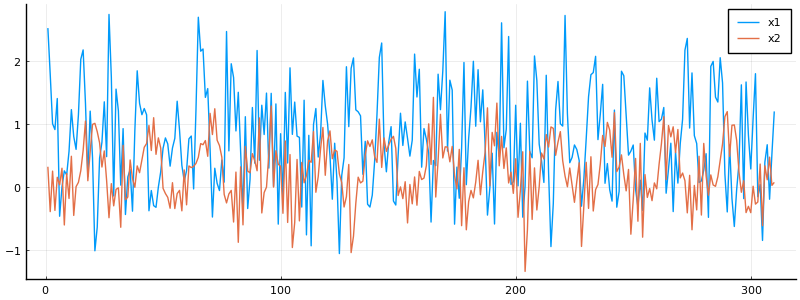

In [917]:
using Distributions, Plots

sys = ChenChainNonlinearSystemNonlinearSincosCouplingModel2(c =0.3, 
    K = 2, γmax = 7, τmax =10, νmax = 7, σ = 0.8,
    As = Uniform(0.2, 0.8),
    αs = Uniform(1.8, 4.0), 
    βs = Uniform(0.05, 0.95),
    ωs = Uniform(5, 30),
    ϕs = Uniform(0, 2pi))

orbit = trajectory(sys, 300, Ttr = 200)
x1 = orbit[:, 1]
x2 = orbit[:, 2]
#x3 = orbit[:, 3]

#x, y = columns(Dataset(orbit));
plot(x1, label = "x1", size = (800, 300))
plot!(x2, label = "x2")
#plot!(x3, label = "x3")

#scatter(x[2:end], x[1:end-1], ms = 0.2, label = "")

In [894]:
function doit_permamp_chen(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, m = 3, N = 5, A = 0.5, b = 2)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            sys = ChenChainNonlinearSystemNonlinearSincosCouplingModel2(c = c_xy, 
                K = 2, γmax = 4, τmax = 4, νmax = 4, σ = 0.8,
                As = Uniform(0.2, 0.8),
                αs = Uniform(1.8, 4.0), βs = Uniform(0.05, 0.95))
            orbit = trajectory(sys, npts, Ttr = 200)
            x = orbit[:, 1]
            y = orbit[:, 2]
            D = Dataset(orbit);
            x, y = columns(D)
            emb = EmbeddingTE()
            xy = transferentropy(x, y, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            yx = transferentropy(y, x, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

function doit_perm_chen(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, m = 3, N = 5, b = 2)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            sys = ChenChainNonlinearSystemNonlinearSincosCouplingModel2(c = c_xy, 
                K = 2, γmax = 4, τmax = 4, νmax = 4, σ = 0.8,
                As = Uniform(0.2, 0.8),
            αs = Uniform(1.8, 4.0), βs = Uniform(0.05, 0.95))
            orbit = trajectory(sys, npts, Ttr = 200)
            x = orbit[:, 1]
            y = orbit[:, 2]
            emb = EmbeddingTE()
            xy = transferentropy(x, y, emb, SymbolicPermutation(m, b = b))
            yx = transferentropy(y, x, emb, SymbolicPermutation(m, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

doit_perm_chen (generic function with 1 method)

In [768]:
D = 5
N = 10
c_xys = 0.0:0.05:3.0
ncoups = length(c_xys)
npts = 3000
nreps = 300

tes_xy_permamp_A0_chen,   tes_yx_permamp_A0_chen = doit_permamp_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0);
tes_xy_permamp_A025_chen, tes_yx_permamp_A025_chen = doit_permamp_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.25);
tes_xy_permamp_A05_chen,  tes_yx_permamp_A05_chen = doit_permamp_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.5);
tes_xy_permamp_A075_chen, tes_yx_permamp_A075_chen = doit_permamp_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.75);
tes_xy_permamp_A1_chen,   tes_yx_permamp_A1_chen = doit_permamp_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 1);

tes_xy_perm_chen, tes_yx_perm_chen = doit_perm_chen(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys);


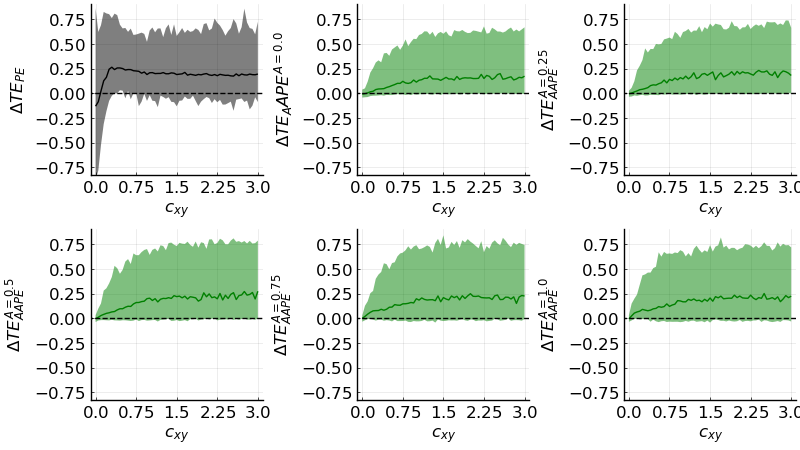

In [778]:
pyplot() ; using LaTeXStrings
lq, uq = 0.025, 0.975

X_permamp_A0_chen = hcat(tes_xy_permamp_A0_chen .- tes_yx_permamp_A0_chen ...)
Δtes_lqs_permamp_A0_chen = [quantile(X_permamp_A0_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A0_chen = [quantile(X_permamp_A0_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A0_chen = [quantile(X_permamp_A0_chen[:, i], 0.5) for i = 1:ncoups];

X_permamp_A025_chen = hcat(tes_xy_permamp_A025_chen .- tes_yx_permamp_A025_chen ...)
Δtes_lqs_permamp_A025_chen = [quantile(X_permamp_A025_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A025_chen = [quantile(X_permamp_A025_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A025_chen = [quantile(X_permamp_A025_chen[:, i], 0.5) for i = 1:ncoups];

X_permamp_A05_chen = hcat(tes_xy_permamp_A05_chen .- tes_yx_permamp_A05_chen ...)
Δtes_lqs_permamp_A05_chen = [quantile(X_permamp_A05_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A05_chen = [quantile(X_permamp_A05_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A05_chen = [quantile(X_permamp_A05_chen[:, i], 0.5) for i = 1:ncoups];

X_permamp_A075_chen = hcat(tes_xy_permamp_A075_chen .- tes_yx_permamp_A075_chen ...)
Δtes_lqs_permamp_A075_chen = [quantile(X_permamp_A075_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A075_chen = [quantile(X_permamp_A075_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A075_chen = [quantile(X_permamp_A075_chen[:, i], 0.5) for i = 1:ncoups];

X_permamp_A1_chen = hcat(tes_xy_permamp_A1_chen .- tes_yx_permamp_A1_chen ...)
Δtes_lqs_permamp_A1_chen = [quantile(X_permamp_A1_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A1_chen = [quantile(X_permamp_A1_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A1_chen = [quantile(X_permamp_A1_chen[:, i], 0.5) for i = 1:ncoups];

X_perm_chen = hcat(tes_xy_perm_chen .- tes_yx_perm_chen ...)
Δtes_lqs_perm_chen = [quantile(X_perm_chen[:, i], lq) for i = 1:ncoups]
Δtes_uqs_perm_chen = [quantile(X_perm_chen[:, i], uq) for i = 1:ncoups]
Δtes_med_perm_chen = [quantile(X_perm_chen[:, i], 0.5) for i = 1:ncoups]

arrs_chen = [Δtes_med_permamp_A0_chen;  Δtes_lqs_permamp_A0_chen;  Δtes_uqs_permamp_A0_chen;
        Δtes_med_permamp_A05_chen; Δtes_lqs_permamp_A05_chen; Δtes_uqs_permamp_A05_chen; 
        Δtes_med_permamp_A1_chen;  Δtes_lqs_permamp_A1_chen;  Δtes_uqs_permamp_A1_chen;
        Δtes_med_perm_chen;        Δtes_lqs_perm_chen;        Δtes_uqs_perm_chen]
maxs_chen = maximum(arrs_chen)
mins_chen = minimum(arrs_chen)
Δte_max = maximum([mins_chen; maxs_chen])*1.05
Δte_min = minimum([mins_chen; maxs_chen])*0.95


pAAPE_A0_chen = plot(c_xys, Δtes_med_permamp_A0_chen, ribbon = (Δtes_med_permamp_A0_chen .- Δtes_lqs_permamp_A0_chen, Δtes_uqs_permamp_A0_chen .- Δtes_med_permamp_A0_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_AAPE^{A = 0.0}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :green, c = :green)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A025_chen = plot(c_xys, Δtes_med_permamp_A025_chen, ribbon = (Δtes_med_permamp_A025_chen .- Δtes_lqs_permamp_A025_chen, Δtes_uqs_permamp_A025_chen .- Δtes_med_permamp_A025_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.25}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :green, c = :green)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A05_chen = plot(c_xys, Δtes_med_permamp_A05_chen, ribbon = (Δtes_med_permamp_A05_chen .- Δtes_lqs_permamp_A05_chen, Δtes_uqs_permamp_A05_chen .- Δtes_med_permamp_A05_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.5}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :green, c = :green)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A075_chen = plot(c_xys, Δtes_med_permamp_A075_chen, ribbon = (Δtes_med_permamp_A075_chen .- Δtes_lqs_permamp_A075_chen, Δtes_uqs_permamp_A075_chen .- Δtes_med_permamp_A075_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.75}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :green, c = :green)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A1_chen = plot(c_xys, Δtes_med_permamp_A1_chen, ribbon = (Δtes_med_permamp_A1_chen .- Δtes_lqs_permamp_A1_chen, Δtes_uqs_permamp_A1_chen .- Δtes_med_permamp_A1_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 1.0}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :green, c = :green)
hline!([0], label = "", c = :black, ls = :dash)

pPE_chen = plot(c_xys, Δtes_med_perm_chen, ribbon = (Δtes_med_perm_chen .- Δtes_lqs_perm_chen, Δtes_uqs_perm_chen .- Δtes_med_perm_chen),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{PE}",
    label = "Symbolic (permutation)", 
    fc = :black, c = :black)
hline!([0], label = "", c = :black, ls = :dash)

plot(pPE_chen, pAAPE_A0_chen, pAAPE_A025_chen,  pAAPE_A05_chen,  pAAPE_A075_chen, pAAPE_A1_chen, 
    layout = (2, 3), size = (800, 450),
    ylims = (Δte_min, Δte_max), label = "", 
    xticks = (0.0:0.75:3.0, 0.0:0.75:3.0),
    tickfont = font(12), guidefont = font(12))

In [779]:
savefig("TEAAPE_chen2D_$(npts)pts_$(nreps)reps_D$(D)_N$(N).pdf")

## Example 3: Rössler-Lorenz system

In [827]:
using SimpleDiffEq

"""
    ContinuousSystemModel{T, N}

An abstract type that represents a set of model parameters of type T for a continous dynamical system,
consisting of `N` variables.

As a minimum, such types always include a field `dt` (giving the sampling time step, which is the 
`dt` argument to `DynamicalSystems.trajectory`) and a field `ui` (giving the initial condition). Hence, 
define a continous model system by (1) its parameters, (2) its initial condition, (3) its sampling rate.

Concrete subtypes must implement the following methods:

- **[`ContinuousDynamicalSystem(x::ContinuousSystemModel)`](@ref)**: 
    Create a `ContinuousDynamicalSystem` from the model.
- **[`get_dt`](@ref)**: Returns the time step.
- **[`get_ui`](@ref)**: Returns the initial condition.
- **[`get_nvars`](@ref)**: Returns the number of variables.
- **[`interaction_matrix`](@ref)**: Returns the interaction matrix for the model (respecting the 
    coupling parameter for that particular model).
- **[`trajectory`](@ref)**. Generate orbits of a given length with internal time 
    scale (sampling step) given by the model's field `dt`.

Concrete subtypes *may* implement the following methods:

- **[`rand`](@ref)**. If implemented for a continuous system model of type `SM`, 
    returns an instance of the model with randomised parameters.
"""
abstract type ContinuousSystemModel{T, N} end #<: AbstractSystemModel{T, N} end 

""" 
    ContinuousDynamicalSystem(x::ContinuousSystemModel) -> ContinuousDynamicalSystem

Convert a system model to a `ContinuousDynamicalSystem` by connecting 
its equations of motion to it parameters.
"""
ContinuousDynamicalSystem(x::ContinuousSystemModel)


function trajectory(x::ContinuousSystemModel{T, N}, npts::Int; sample_dt::Int = 1, Ttr = 1000, 
    alg = SimpleDiffEq.SimpleATsit5()) where {T, N}

    sys = ContinuousDynamicalSystem(x)
    time = npts*x.dt*sample_dt

    o = trajectory(sys, time, dt = x.dt, Ttr = Ttr*x.dt, alg = alg)[1:sample_dt:end-1, :]

    percent_noise = x.observational_noise_level
    if x.observational_noise_level > 0
        o = add_observational_noise!(o, percent_noise)
    end

    return o
end

"""
    RosslerLorenzUnidir{T, 6} <: ContinuousSystemModel{T, N}

Create a 6D Rössler-Lorenz model consisting of two independent 3D subsystems:
one Rössler system and one Lorenz system (from [^1]). They are coupled such that the
second component (`x₂`) of the Rössler system unidirectionally forces the
second component (`y₂`) of the Lorenz system. 

The parameter `c_xy` controls the coupling strength. The implementation here also 
allows for tuning the parameters of each subsystem by introducing the constants 
`a₁`, `a₂`, `a₃`, `b₁`, `b₂`, `b₃`. Default values for these parameters are 
as in [^1].

## Equations of motion 

The dynamics is generated by the following vector field

```math
\\begin{aligned}
\\dot x_1 &= a_1(x_2 + x_3) \\\\
\\dot x_2 &= a_2(x_1 + 0.2x_2) \\\\
\\dot x_3 &= a_2(0.2 + x_3(x_1 - a_3)) \\\\
\\dot y_1 &= b_1(y_2 - y_1) \\\\
\\dot y_2 &= y_1(b_2 - y_3) - y_2 +c_{xy}(x_2)^2 \\\\
\\dot y_3 &= y_1 y_2 - b_3y_3
\\end{aligned}
```

with the coupling constant ``c_{xy} \\geq 0``.

## Fields

- **`ui::SVector{6, T}`**: The initial condition.
- **`dt::T`**: The time step.
- **`c_xy::T`**: The coupling strength between the systems.
- **`a₁::T`**: The parameter `a₁` controlling the Rössler subsystem.
- **`a₂::T`**: The parameter `a₂` controlling the Rössler subsystem.
- **`a₃::T`**: The parameter `a₃` controlling the Rössler subsystem.
- **`b₁::T`**: The parameter `b₁` controlling the Lorenz subsystem.
- **`b₂::T`**: The parameter `b₂` controlling the Lorenz subsystem.
- **`b₃::T`**: The parameter `b₃` controlling the Lorenz subsystem.
- **`observational_noise_level`**: The magnitude of observational noise to add after sampling 
    orbits of the system (given as percentage of empirical standard deviation). If 
    `observational_noise_level = 30`, then noise equivalent to 0.3 times the empirical standard 
    deviation will be added to each variable of the system (taking the standard deviation for 
    that variable only).

## Implements 

- [`rand(::Type{RosslerLorenzUnidir})`](@ref). This method creates an instance of `RosslerLorenzUnidir`
    with randomised parameters.

    ## References

[^1]:
    Krakovská, Anna, et al. "Comparison of six methods for the detection of causality in a 
    bivariate time series." Physical Review E 97.4 (2018):042207. 
    [https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.042207](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.042207)
    
"""
struct RosslerLorenzUnidir2{T, N} <: ContinuousSystemModel{T, N}
    eom::Function
    ui::SVector{N, T}
    dt::T
    c_xy::T
    a₁::T
    a₂::T
    a₃::T
    b₁::T
    b₂::T
    b₃::T
    observational_noise_level::T # how much observational noise to add?
end

function get_varnames(x::RosslerLorenzUnidir2, latex = true)
    varnames = ["x_1", "x_2", "x_3", "y_1", "y_2", "y_3"]
    if latex
        return latexstring.(varnames)
    else
        return varnames
    end
end

get_vars(x::RosslerLorenzUnidir2) = [:x_1, :x_2, :x_3, :y_1, :y_2, :y_3]


@inline @inbounds function eom_RosslerLorenzUnidir2(u, p::RosslerLorenzUnidir2, t)
    
    x1, x2, x3, y1, y2, y3 = u[1], u[2], u[3], u[4], u[5], u[6] 
    
    dx1 = -p.a₁*(x2 + x3)
    dx2 = p.a₁*(x1 + p.a₂*x2)
    dx3 = p.a₁*(p.a₂ + x3*(x1 - p.a₃))
    dy1 = p.b₁*(-y1 + y2)
    dy2 = p.b₂*y1 - y2 - y1*y3 + p.c_xy*(x2^2)
    dy3 = y1*y2 - p.b₃*y3
    
    return SVector{6}(dx1, dx2, dx3, dy1, dy2, dy3)
end


function RosslerLorenzUnidir2(; ui::AbstractVector{T} = rand(6), c_xy = 1.0, 
        a₁ = 6, a₂ = 0.2, a₃ = 5.7, b₁ = 10, b₂ = 28, b₃ = 8/3, 
        observational_noise_level = 20,
        dt = 0.05) where T <: AbstractFloat
    
    if dt <= 0
        error("Time step `dt` must be positive!")
    end
    if length(ui) != 6
        error("Number of elements in initial condition must match 6")
    end
    ps = T.([dt, c_xy, a₁, a₂, a₃, b₁, b₂, b₃, observational_noise_level])
    RosslerLorenzUnidir2(eom_RosslerLorenzUnidir2, SVector{6, T}(ui), ps...)
end


function ContinuousDynamicalSystem(x::RosslerLorenzUnidir2{T, N}) where {T, N}
    ContinuousDynamicalSystem(x.eom, x.ui, x)
end

function trajectory(model::RosslerLorenzUnidir2, npts::Int; sample_dt::Int = 1, n_transient = 5000, Ttr = n_transient * model.dt)
    
    sys = ContinuousDynamicalSystem(model)
    # the system is recorded at times t0:dt:T
    T = npts*model.dt*sample_dt
    
    o = DynamicalSystemsBase.trajectory(sys, T, 
        dt = model.dt, 
        Ttr = n_transient*model.dt, 
        alg = SimpleDiffEq.SimpleATsit5()) #alg = SimpleDiffEq.SimpleATsit5()
    
    return o[1:sample_dt:end-1, :]
    
end

trajectory (generic function with 5 methods)

### Test the system

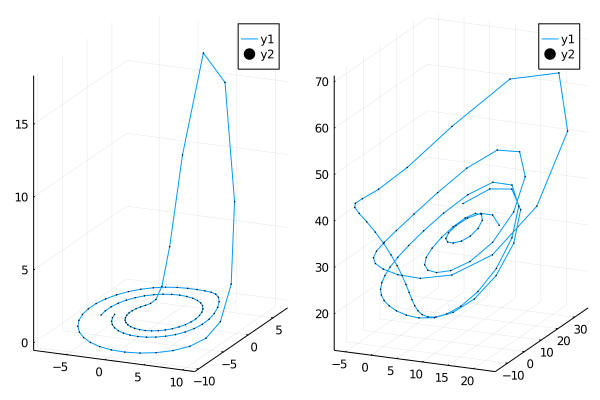

In [952]:
gr()
model = RosslerLorenzUnidir2(c_xy = 3, dt = 0.03)
npts = 100
orbit = trajectory(model, npts, Ttr = 5000)
x1, x2, x3, y1, y2, y3 = columns(orbit);

py = plot(y2, label = L"y_2")
py = plot(y1, y2, y3)
scatter!(y1, y2, y3, ms = 1.0, c = :black)

px = plot(x2, label = L"x_2")
px = plot(x1, x2, x3)
scatter!(x1, x2, x3, ms = 1.0, c = :black)


plot(px, py)

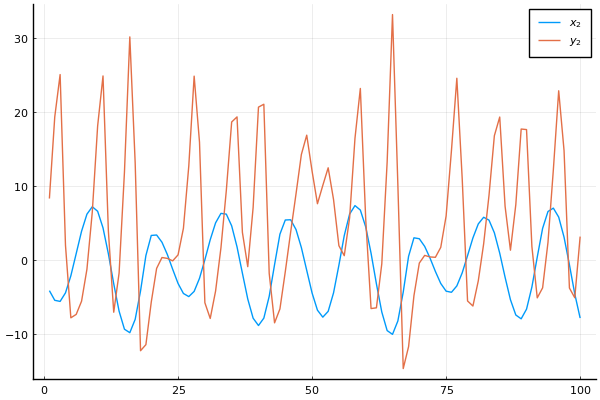

### Apply transfer entropy estimators

In [863]:
function doit_permamp_RL(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, dt = 0.03, m = 3, N = 5, A = 0.5, b = 2, kwargs...)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            model = RosslerLorenzUnidir2(c_xy = c_xy, dt = dt; 
                #a₁ = rand(Uniform(5.95, 6.05)), 
                #a₂ = rand(Uniform(0.18, 0.22)), 
                #a₃ = rand(Uniform(0.56, 0.58)), 
                #b₁ = rand(Uniform(9.5, 10.5)), 
                #b₂ = rand(Uniform(27, 29)), 
                #b₃ = rand(Uniform(7/3, 9/3)),
                kwargs...)
            orbit = trajectory(model, npts)
            x1, x2, x3, y1, y2, y3 = columns(orbit);
            emb = EmbeddingTE()
            xy = transferentropy(x2, y2, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            yx = transferentropy(y2, x2, emb, SymbolicPermutationAmplitude(m, N = N, A = A, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

function doit_perm_RL(; npts = 1000, nreps = 10, c_xys = 0.0:0.05:1.4, dt = 0.03, m = 3, N = 5, b = 2,  kwargs...)
    L = length(c_xys)
    tes_xy = [zeros(nreps) for i = 1:L]
    tes_yx = [zeros(nreps) for i = 1:L]


    for (i, c_xy) in enumerate(c_xys)
        te_xy = Float64[]
        te_yx = Float64[]
        for i = 1:nreps
            model = RosslerLorenzUnidir2(c_xy = c_xy, dt = dt, 
                #a₁ = rand(Uniform(5.95, 6.05)), 
                #a₂ = rand(Uniform(0.18, 0.22)), 
                #a₃ = rand(Uniform(0.56, 0.58)), 
                #b₁ = rand(Uniform(9.5, 10.5)), 
                #b₂ = rand(Uniform(27, 29)), 
                #b₃ = rand(Uniform(7/3, 9/3))
                ; kwargs...)
            
            orbit = trajectory(model, npts)
            x1, x2, x3, y1, y2, y3 = columns(orbit);
            emb = EmbeddingTE()
            xy = transferentropy(x2, y2, emb, SymbolicPermutation(m, b = b))
            yx = transferentropy(y2, x2, emb, SymbolicPermutation(m, b = b))
            push!(te_xy, xy)
            push!(te_yx, yx)
        end
        tes_xy[i] = te_xy
        tes_yx[i] = te_yx
    end
    return tes_xy, tes_yx
end

doit_perm_RL (generic function with 1 method)

In [929]:
D = 3
N = 10
c_xys = 0.0:0.1:4.0
ncoups = length(c_xys)
npts = 2000
nreps = 30

tes_xy_perm_RL, tes_yx_perm_RL = doit_perm_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys);

tes_xy_permamp_A0_RL,   tes_yx_permamp_A0_RL = doit_permamp_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0);
tes_xy_permamp_A025_RL, tes_yx_permamp_A025_RL = doit_permamp_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.25);
tes_xy_permamp_A05_RL,  tes_yx_permamp_A05_RL = doit_permamp_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.5);
tes_xy_permamp_A075_RL, tes_yx_permamp_A075_RL = doit_permamp_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 0.75);
tes_xy_permamp_A1_RL,   tes_yx_permamp_A1_RL = doit_permamp_RL(npts = npts, nreps = nreps, m = D, N = N, c_xys = c_xys, A = 1);



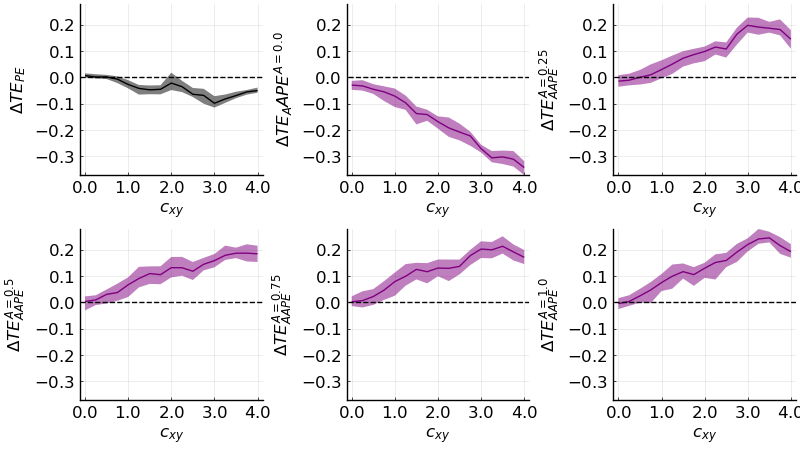

In [891]:
pyplot() ; using LaTeXStrings
lq, uq = 0.025, 0.975

X_permamp_A0_RL = hcat(tes_xy_permamp_A0_RL .- tes_yx_permamp_A0_RL ...)
Δtes_lqs_permamp_A0_RL = [quantile(X_permamp_A0_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A0_RL = [quantile(X_permamp_A0_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A0_RL = [quantile(X_permamp_A0_RL[:, i], 0.5) for i = 1:ncoups];

X_permamp_A025_RL = hcat(tes_xy_permamp_A025_RL .- tes_yx_permamp_A025_RL ...)
Δtes_lqs_permamp_A025_RL = [quantile(X_permamp_A025_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A025_RL = [quantile(X_permamp_A025_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A025_RL = [quantile(X_permamp_A025_RL[:, i], 0.5) for i = 1:ncoups];

X_permamp_A05_RL = hcat(tes_xy_permamp_A05_RL .- tes_yx_permamp_A05_RL ...)
Δtes_lqs_permamp_A05_RL = [quantile(X_permamp_A05_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A05_RL = [quantile(X_permamp_A05_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A05_RL = [quantile(X_permamp_A05_RL[:, i], 0.5) for i = 1:ncoups];

X_permamp_A075_RL = hcat(tes_xy_permamp_A075_RL .- tes_yx_permamp_A075_RL ...)
Δtes_lqs_permamp_A075_RL = [quantile(X_permamp_A075_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A075_RL = [quantile(X_permamp_A075_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A075_RL = [quantile(X_permamp_A075_RL[:, i], 0.5) for i = 1:ncoups];

X_permamp_A1_RL = hcat(tes_xy_permamp_A1_RL .- tes_yx_permamp_A1_RL ...)
Δtes_lqs_permamp_A1_RL = [quantile(X_permamp_A1_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_permamp_A1_RL = [quantile(X_permamp_A1_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_permamp_A1_RL = [quantile(X_permamp_A1_RL[:, i], 0.5) for i = 1:ncoups];

X_perm_RL = hcat(tes_xy_perm_RL .- tes_yx_perm_RL ...)
Δtes_lqs_perm_RL = [quantile(X_perm_RL[:, i], lq) for i = 1:ncoups]
Δtes_uqs_perm_RL = [quantile(X_perm_RL[:, i], uq) for i = 1:ncoups]
Δtes_med_perm_RL = [quantile(X_perm_RL[:, i], 0.5) for i = 1:ncoups]

arrs_RL = [Δtes_med_permamp_A0_RL;  Δtes_lqs_permamp_A0_RL;  Δtes_uqs_permamp_A0_RL;
           Δtes_med_permamp_A05_RL; Δtes_lqs_permamp_A05_RL; Δtes_uqs_permamp_A05_RL; 
           Δtes_med_permamp_A1_RL;  Δtes_lqs_permamp_A1_RL;  Δtes_uqs_permamp_A1_RL;
           Δtes_med_perm_RL;        Δtes_lqs_perm_RL;        Δtes_uqs_perm_RL]
maxs_RL = maximum(arrs_RL)
mins_RL = minimum(arrs_RL)
Δte_max = maximum([mins_RL; maxs_RL])
Δte_min = minimum([mins_RL; maxs_RL])


pAAPE_A0_RL = plot(c_xys, Δtes_med_permamp_A0_RL, ribbon = (Δtes_med_permamp_A0_RL .- Δtes_lqs_permamp_A0_RL, Δtes_uqs_permamp_A0_RL .- Δtes_med_permamp_A0_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_AAPE^{A = 0.0}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :purple, c = :purple)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A025_RL = plot(c_xys, Δtes_med_permamp_A025_RL, ribbon = (Δtes_med_permamp_A025_RL .- Δtes_lqs_permamp_A025_RL, Δtes_uqs_permamp_A025_RL .- Δtes_med_permamp_A025_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.25}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :purple, c = :purple)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A05_RL = plot(c_xys, Δtes_med_permamp_A05_RL, ribbon = (Δtes_med_permamp_A05_RL .- Δtes_lqs_permamp_A05_RL, Δtes_uqs_permamp_A05_RL .- Δtes_med_permamp_A05_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.5}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :purple, c = :purple)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A075_RL = plot(c_xys, Δtes_med_permamp_A075_RL, ribbon = (Δtes_med_permamp_A075_RL .- Δtes_lqs_permamp_A075_RL, Δtes_uqs_permamp_A075_RL .- Δtes_med_permamp_A075_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 0.75}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :purple, c = :purple)
hline!([0], label = "", c = :black, ls = :dash)

pAAPE_A1_RL = plot(c_xys, Δtes_med_permamp_A1_RL, ribbon = (Δtes_med_permamp_A1_RL .- Δtes_lqs_permamp_A1_RL, Δtes_uqs_permamp_A1_RL .- Δtes_med_permamp_A1_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{AAPE}^{A = 1.0}", 
    label = "Symbolic (amplitude + permutation)", 
    fc = :purple, c = :purple)
hline!([0], label = "", c = :black, ls = :dash)

pPE_RL = plot(c_xys, Δtes_med_perm_RL, ribbon = (Δtes_med_perm_RL .- Δtes_lqs_perm_RL, Δtes_uqs_perm_RL .- Δtes_med_perm_RL),
    xlabel = L"c_{xy}",
    ylabel = L"\Delta TE_{PE}",
    label = "Symbolic (permutation)", 
    fc = :black, c = :black)
hline!([0], label = "", c = :black, ls = :dash)

plot(pPE_RL, pAAPE_A0_RL, pAAPE_A025_RL,  pAAPE_A05_RL,  pAAPE_A075_RL, pAAPE_A1_RL, 
    layout = (2, 3), size = (800, 450),
    ylims = (Δte_min, Δte_max), label = "", 
    xticks = (0.0:1:4.0, 0.0:1:4.0),
    tickfont = font(12), guidefont = font(12))